# 1. BUSINESS PROBLEM

### 1.1 DESCRIPTION

The data was collected through surveys by the Central Bureau of Statistics that work under the National Planning Commission Secretariat of Nepal. This survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.
We're trying to predict the ordinal variable damage_grade, which represents a level of damage to the building that was hit by the earthquake.

### 1.2 SOURCES

DATA SOURCE: https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/

### 1.3 Real World / Business Objectives and Constraints

1. Accurately predict the damage inflicted by the earthquake.
2. No strict latency contraints.

# 2. Machine Learning Overview

### 2.1 DATA OVERVIEW

The dataset mainly consists of information on the buildings' structure and their legal ownership. Each row in the dataset represents a specific building in the region that was hit by Gorkha earthquake.

There are 39 columns in this dataset, where the building_id column is a unique and random identifier. The remaining 38 features are described in the section below. Categorical variables have been obfuscated random lowercase ascii characters. The appearance of the same character in distinct columns does not imply the same original value.

### 2.2 TYPE OF PROBLEM

This is a multi class classification problem since we need to predict which level of damage was inflicted upon the building by the earthquake.

### 2.3 PERFOMANCE METRICS

We are predicting the level of damage from 1 to 3. The level of damage is an ordinal variable meaning that ordering is important. This can be viewed as a classification or an ordinal regression problem. (Ordinal regression is sometimes described as an problem somewhere in between classification and regression.)

To measure the performance of our algorithms, we'll use the F1 score which balances the precision and recall of a classifier. Traditionally, the F1 score is used to evaluate performance on a binary classifier, but since we have three possible labels we will use a variant called the micro averaged F1 score.

Fmicro=2⋅Pmicro⋅RmicroPmicro+Rmicro
where

Pmicro=∑3k=1TPk∑3k=1(TPk+FPk),  Rmicro=∑3k=1TPk∑3k=1(TPk+FNk)
and TP is True Positive, FP is False Positive, FN is False Negative, and k represents each class in 1,2,3

# 3. Exploratory Data Analysis

In [4]:
!pip install numpy --upgrade
!pip3 install numpy --upgrade

Requirement already up-to-date: numpy in c:\users\bobby's zone\appdata\local\programs\python\python36\lib\site-packages (1.18.0)
Requirement already up-to-date: numpy in c:\users\bobby's zone\appdata\local\programs\python\python36\lib\site-packages (1.18.0)


In [32]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score

In [14]:
from imblearn.over_sampling import SMOTE

In [2]:
train_df=pd.read_csv("train_values.csv")
train_df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_labels=pd.read_csv("train_labels.csv")
train_labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [4]:
train_df['damage_grade']=train_labels['damage_grade']

In [5]:
train_df.shape

(260601, 40)

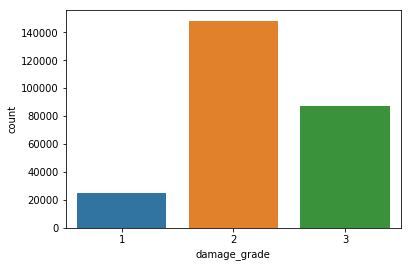

In [6]:
sns.countplot(train_df['damage_grade'])

We can see that it is an imbalanced data set with majority of damage grade falling in class 2.

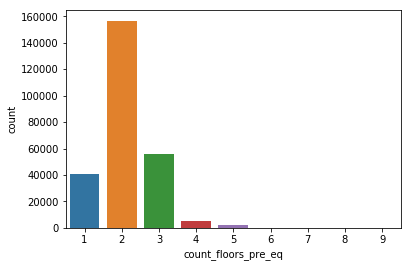

In [7]:
sns.countplot(train_df['count_floors_pre_eq'])

Majority of the buildings have 2 floor pre earthquake.

(array([5.9738e+04, 7.4906e+04, 5.6548e+04, 2.8738e+04, 1.5270e+04,
        9.2900e+03, 4.7350e+03, 2.4870e+03, 3.9020e+03, 1.4990e+03,
        1.4530e+03, 1.2100e+02, 2.1700e+02, 1.4000e+01, 1.2000e+01,
        1.4300e+02, 8.0000e+00, 1.1000e+01, 8.0000e+00, 5.0000e+00,
        1.0600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

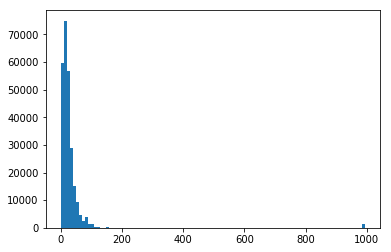

In [8]:
plt.hist(train_df['age'],bins=100)

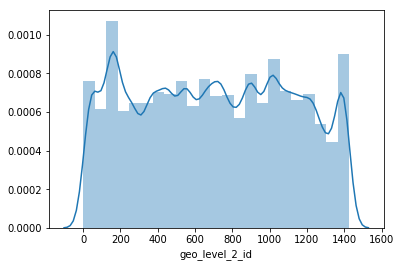

In [9]:
sns.distplot(train_df['geo_level_2_id'], bins = 23)

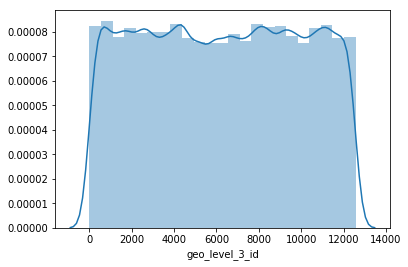

In [10]:
sns.distplot(train_df['geo_level_3_id'], bins = 23)

In [11]:
train_df.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

In [9]:
category_cols = ['roof_type', 'foundation_type', 'land_surface_condition', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
train_df = pd.get_dummies(train_df, columns = category_cols)

In [10]:
y=train_df['damage_grade']

In [11]:
train_df.drop(['building_id', 'damage_grade'], axis = 1, inplace = True)
train_df.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,6,487,12198,2,30,6,5,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1,8,900,2812,2,10,8,7,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,21,363,8973,2,10,5,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,22,418,10694,2,10,6,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,11,131,1488,3,30,8,9,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
# To check feature importance
model = ExtraTreesClassifier()
model.fit(train_df,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=train_df.columns)


[1.27184860e-01 1.18130195e-01 1.32782447e-01 2.01434675e-02
 1.48554280e-01 1.36367997e-01 6.82031102e-02 7.84761716e-03
 1.28025124e-02 5.96813036e-03 3.63269458e-03 6.04156324e-03
 8.96983212e-03 1.01031553e-02 6.33336474e-03 4.93842103e-03
 2.48147700e-03 3.64892291e-03 2.86901689e-02 5.24086797e-03
 3.20235634e-03 3.00506954e-03 1.27290122e-03 2.88054980e-04
 1.47183556e-04 3.99201446e-04 6.45492351e-05 4.97015012e-05
 3.62095806e-05 1.11610315e-03 4.84158942e-03 4.78241593e-03
 5.69348674e-03 1.05112833e-03 5.99776921e-03 1.44641459e-02
 2.78114260e-03 4.99272743e-03 5.51916256e-03 3.24775735e-03
 6.39601122e-03 6.27307191e-03 5.05462998e-04 1.02077295e-02
 4.82996202e-03 6.71643709e-04 3.48245351e-03 5.93277205e-03
 2.83186378e-03 3.55983613e-03 3.37388667e-03 1.00606012e-03
 5.82335386e-03 5.12293800e-03 3.02237192e-04 3.61936922e-04
 3.99841664e-03 2.91474780e-05 5.90386648e-05 7.84387620e-05
 2.14205990e-04 3.10010946e-03 4.38236257e-04 2.25904752e-03
 2.21421397e-03 1.219953

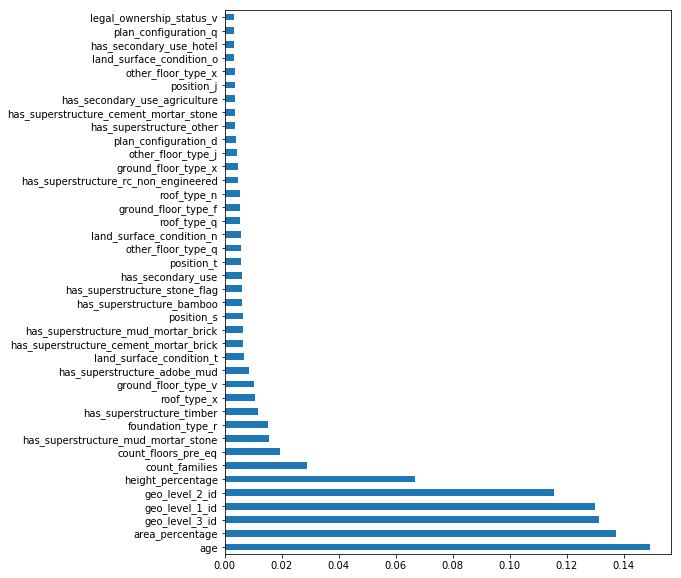

In [16]:
figure(figsize=(8, 10))
feat_importances.nlargest(40).plot(kind='barh')
plt.show()

In [15]:
smt = SMOTE()
train_df, y = smt.fit_sample(train_df, y)

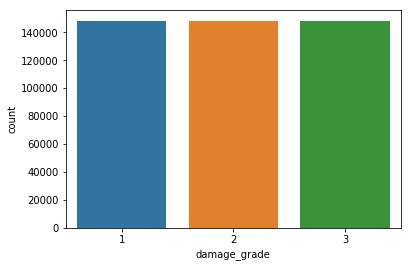

In [16]:
sns.countplot(y)

In [ ]:
import pickle
train_df.to_pickle("train_data")
y.to_pickle("labels")


# 4. Modeling

In [17]:
x_train, x_val, y_train, y_val = train_test_split(train_df, y, test_size = 0.20, random_state = 42)

In [ ]:
classifiers = [
    DecisionTreeClassifier(),
    KNeighborsClassifier(3), 
    SVC(),
    GaussianNB(),
    LogisticRegression(),
    RandomForestClassifier(),
    XGBClassifier()
   
]

names = []
f1 = []
accuracy = []

for clf in classifiers:
    clf = clf.fit(x_train, y_train)
    y_pred = clf.predict(x_val)
    
    names.append(clf.__class__.__name__)
    f1.append(f1_score(y_val, y_pred,average='micro'))
    accuracy.append(accuracy_score(y_val, y_pred))

score_df = pd.DataFrame({'Model': names, 'F1_score': f1, 'accuracy':accuracy}).set_index('Model')
score_df=score_df.sort_values(by=['F1_score'], ascending=False)
score_df